# Growth direction verification
Test for checking the direction of the thermal gradient direction and to find the easy growth direction according to Euler-Bunges convention angles

## Function under the spot lights:
* 'compute_normalized_gradient_at_point'
* 'compute_easy_growth_directions'

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from grain_growth_model.core.meltpool import compute_normalized_gradient_at_point
from grain_growth_model.core.growth import compute_easy_growth_directions

## Test

### Set the test values

In [ ]:
crystal_dirs = np.array([
    [1, 0, 0], 
    [0, 1, 0], 
    [0, 0, 1],
    [-1, 0, 0], 
    [0, -1, 0], 
    [0, 0, -1]
    ])

# --- melt pool description --
meltpool = {
    "width": 2.0,     # along Y
    "height": 0.5,    # along Z
    "length": 4.0,     # along X
    "PD": 1,
    "epitaxy": False
}
zc = 0.5  # z-center (substrate height)
yc = 0.0  # y-center
xc = 0.0  # x-center
simulation_width = 1.5

# --- test point à x=0, on the bottom half of the ellipsoid ---
y_test = 0.3
z_test = zc - meltpool["height"] * np.sqrt(1 - (2 * y_test / meltpool["width"])**2)
point = np.array([[0.0, y_test, z_test]])

assert z_test < zc, "Le point n'est pas dans la partie inférieure de l’ellipsoïde"


# --- Crystal orientation - Euler-Bunges angles ---
fake_orientations = np.array([[0.0, 0.0, 0.0]])  # euler angles (radians)

#### Plot initialization

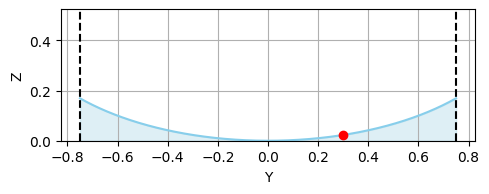

In [6]:
# Section en Y
y = np.linspace(-simulation_width / 2, simulation_width / 2, 1000)
z = zc - meltpool["height"] * np.sqrt(1 - (2 * y / meltpool["width"]) ** 2)
z[np.isnan(z)] = np.nan

# Affichage 2D
fig, ax = plt.subplots(figsize=(5, 6))
ax.plot(y, z, color='skyblue', label='Ellipsoid section')
ax.fill_between(y, 0, z, color='lightblue', alpha=0.4)
ax.plot(y_test, z_test, 'ro', label='Test point')

ax.axvline(-simulation_width / 2, color='k', linestyle='--')
ax.axvline(simulation_width / 2, color='k', linestyle='--')
ax.set_aspect('equal')
ax.set_xlabel("Y")
ax.set_ylabel("Z")
ax.set_ylim(0, 1.05*meltpool["height"])
# ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Compute the growth directions

In [8]:
# --- thermal gradient on the test point ---
gradient = compute_normalized_gradient_at_point(
    y=point[:, 1],
    z=point[:, 2],
    meltpool=meltpool,
    z_center=zc
)
assert np.linalg.norm(gradient[0]) - 1 < 1e-6

# --- easy growth direction --
growth_dirs = compute_easy_growth_directions(
    euler_angles=fake_orientations,
    thermal_gradient=gradient,
    crystal_directions=crystal_dirs,
    y_positions=point[:, 1],
    simulation_width=simulation_width
)

## Plot results

#### 2D

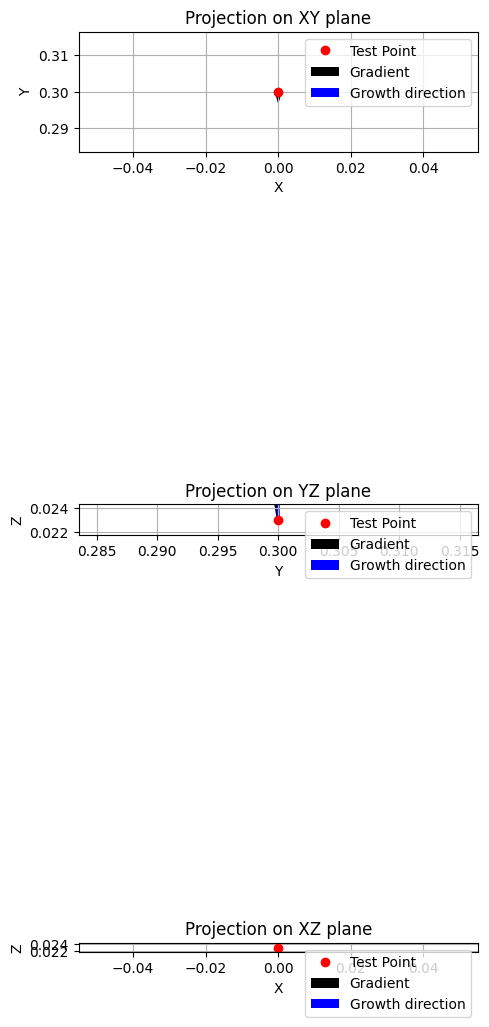

In [10]:
# --- Préparation des 3 plans de projection ---
fig, axs = plt.subplots(3, 1, figsize=(5, 15))
planes = ['XY', 'YZ', 'XZ']
coords = point[0]
vec_grad = gradient[0]
vec_growth = growth_dirs[0]

# --- Boucle sur les 3 plans ---
for ax, plane in zip(axs, planes):
    if plane == 'XY':
        i, j = 0, 1
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
    elif plane == 'YZ':
        i, j = 1, 2
        ax.set_xlabel('Y')
        ax.set_ylabel('Z')
    elif plane == 'XZ':
        i, j = 0, 2
        ax.set_xlabel('X')
        ax.set_ylabel('Z')

    ax.plot(coords[i], coords[j], 'ro', label='Test Point')
    ax.quiver(coords[i], coords[j], vec_grad[i], vec_grad[j], color='black', scale=5, label='Gradient')
    ax.quiver(coords[i], coords[j], vec_growth[i], vec_growth[j], color='blue', scale=5, label='Growth direction')
    ax.set_title(f"Projection on {plane} plane")
    ax.set_aspect('equal')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

#### 3D

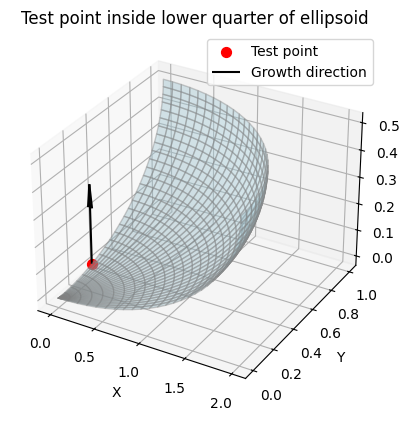

In [11]:
u = np.linspace(0, np.pi / 2, 30)
v = np.linspace(0, np.pi / 2, 30)
x = (meltpool["length"] / 2) * np.outer(np.cos(u), np.sin(v))
y = (meltpool["width"] / 2) * np.outer(np.sin(u), np.sin(v))
z = zc - meltpool["height"] * np.outer(np.ones_like(u), np.cos(v))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, color='lightblue', alpha=0.4, edgecolor='gray')

ax.scatter(point[:, 0], point[:, 1], point[:, 2], color='red', s=50, label='Test point')
ax.quiver(
    point[0, 0], point[0, 1], point[0, 2],
    growth_dirs[0, 0], growth_dirs[0, 1], growth_dirs[0, 2],
    length=0.3, color='black', label='Growth direction'
)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Test point inside lower quarter of ellipsoid")
ax.legend()
plt.show()